<a href="https://www.kaggle.com/code/researchlad/hand-recognition?scriptVersionId=125428821" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

##### DNN for Hand Recognition

TODO: 
1. Normalize the data over the feature columns 

```
def normalizeData(arr):
  stdArr = np.std(arr)
  meanArr = np.mean(arr)
  arr = (arr-meanArr)/stdArr
  return arr

for str1 in wineFeatures.columns:
   wineFeatures[str1] = normalizeData(wineFeatures[str1])
```
2. Data Augmentation
3. NN Pruning
4. Down sample instead of truncating longer frame sequences

WHY IS OUR VALIDATION SCORE SO BAD


# Imports and Training Params

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import json
import zipfile
import os
import gc
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BASE_TRAIN_PATH = "/kaggle/input/asl-signs/"
TRAIN_FILE = "/kaggle/input/asl-signs/train.csv"
INDEX_MAP_FILE = '/kaggle/input/asl-signs/sign_to_prediction_index_map.json'
MODEL_OUT_PATH = '/kaggle/working/modelie'


use_generator = True # Otherwise will load data to disk  
find_optimal_params = False
filter_outliers = True # Currently unused 
drop_z = True
local_inference_test = False

epochs = 5
batch_size = 64 # Best to have powers of 2
max_length = 60 # length that input is padded/truncated to 
Learning_Rate = .001 # Best from keras is .0001

rows_per_frame = 543 #Number of landmarks per frame 
num_classes = 250 
dropout_rate = .3

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET+21
RIGHT_HAND_OFFSET = POSE_OFFSET+33
ROWS_PER_FRAME = 543
lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409, 291,146, 91, 181, 84, 17, 314, 405, 321, 375, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 95, 88, 178, 87, 14,317, 402, 318, 324, 308]

left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET+21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET+21))

hand_landmarks = left_hand_landmarks + right_hand_landmarks 

point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks] for item in sublist]

train = pd.read_csv(TRAIN_FILE)
with open(INDEX_MAP_FILE, 'r') as f: 
    index_map = json.load(f)

train['label'] = train['sign'].map(lambda x: index_map[x])

if drop_z: 
    data_columns = ['x', 'y']
else: 
    data_columns = ['x', 'y', 'z']

# Process frame path during training

In [2]:
def process_frame(path): 
    data = pd.read_parquet(os.path.join(BASE_TRAIN_PATH, path), columns=['x', 'y', 'z'])
        
    n = int(len(data)/rows_per_frame)
    
    data = data.values.reshape(n, rows_per_frame, len(['x', 'y', 'z'])).astype(np.float32)
    
    if drop_z:
        data = data[:, : , :2]

    nan_hands = list(set(np.where(np.all(np.isnan(data[:, hand_landmarks, :]), axis=1))[0]))
    
    if nan_hands: 
        data = np.delete(data, nan_hands, axis=0)
    
    data = np.nan_to_num(data)
    
    data = data[:, point_landmarks, :] # filter for the relevant pose landmarks 
    
        
    data = np.reshape(data, (data.shape[0], len(point_landmarks)*len(data_columns)), order = 'C').astype(np.float32)
    
    data = data[:max_length, :] # In case we had too many frames 
    
    if data.shape[0] < max_length: 
        data = np.pad(data, ((0, max_length - data.shape[0]),(0,0)))
        
    return data

# Multiprocessed Data Loading (to Disk)
-Faster

In [3]:
if not use_generator: 
    train_paths = [train.iloc[i].path for i in range(int(len(train)))]
    y = [train.iloc[i].label for i in range(int(len(train)))]

    with Pool(processes=10) as pool: 
        x = list(tqdm(pool.imap(process_frame, train_paths, chunksize=1000), total = 100))
        pool.close()

    x = np.array(x)
    y = np.array(y)
    #x = tf.keras.utils.pad_sequences(x_ragged, padding="post", truncating="post", maxlen = max_length, dtype=np.float32)
    
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1) 

    del x , y
    gc.collect()

# Data Generator
-Allows us to load more data than can fit in memory

In [4]:
class DataGenerator(tf.keras.utils.Sequence): 
    def __init__(self, train, list_IDs, point_landmarks, batch_size=32, max_length=30, rows_per_frame=543, 
                 data_columns=['x','y','z'], shuffle=True):
        self.train = train
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.max_length = max_length 
        self.rows_per_frame = rows_per_frame
        self.point_landmarks = point_landmarks
        self.data_columns = data_columns 
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, self.max_length, len(self.point_landmarks)*len(self.data_columns)))
        y = np.empty((self.batch_size), dtype=int)
        
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = process_frame(train.iloc[ID].path)
            y[i] = self.train.iloc[ID].label
            
        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

if use_generator: 
    ds_params = {'max_length': max_length, 'batch_size': batch_size, 'rows_per_frame': rows_per_frame,'data_columns': data_columns, 'shuffle': True}
    partition = {'train': [i for i in range(int(len(train)*.8))], 'validation': [j for j in range(int(len(train)*.8), len(train))]}

    training_generator = DataGenerator(train, partition['train'], point_landmarks, **ds_params)
    validation_generator = DataGenerator(train, partition['validation'], point_landmarks, **ds_params)

### Frames Stats
Mean: 37.935
Median: 22
StdDev: 44.177
Max: 537
Min: 2

### Best Model Params
160               |units

480               |units_2

416               |units_3

0.0001            |learning_rate             

In [5]:
def get_model(units_1, units_2, units_3): 
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(max_length, len(point_landmarks)*len(data_columns)), dtype=np.float32), 
        tf.keras.layers.Masking(mask_value=0, input_shape=(max_length, len(point_landmarks)*3)),
        tf.keras.layers.Dense(units=units_1 , activation='relu'), # Generally want hidden layers to be between the size of the input and output layers 
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LayerNormalization(), 
        tf.keras.layers.Dense(units=units_2, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LayerNormalization(), 
        tf.keras.layers.LSTM(units_3),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = num_classes, activation='softmax', name='outie'), # Output size is <256>
    ])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=Learning_Rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model 

model = get_model(160, 480, 416) 

# Optimal Hyper Parameter Search

In [6]:
!pip install -q -U keras-tuner
import keras_tuner as kt 

def get_tuned_model(hp): 
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    model = get_model(hp_units, hp_units_2, hp_units_3)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model 

if find_optimal_params: 
    tuner = kt.Hyperband(get_tuned_model,
                         objective='val_accuracy',
                         max_epochs=10,
                         factor=3,
                         directory='kaggle/working',
                         project_name='intro_to_kt')

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    tuner.search(training_generator, validation_data=validation_generator, epochs=50, callbacks=[stop_early])

    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    print(best_hps.get('units'))
    print(best_hps.get('units2'))
    print(best_hps.get('units3'))
    print(best_hps.get('learning_rate'))
    model = tuner.hypermodel.build(best_hps)

    history = model.fit(training_generator, validation_data=validation_generator, epochs=50)
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))
    epochs = best_epoch

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


# Model fitting using either Data Generator or Numpy Arrays

In [7]:
callbacks = [
        EarlyStopping(
                monitor = "val_accuracy",
                min_delta = 0, # minimium amount of change to count as an improvement
                patience = 5, # how many epochs to wait before stopping
                restore_best_weights=True),
    
        ReduceLROnPlateau(monitor = "val_accuracy",
            factor = 0.5,
            patience = 5)
            ]

if use_generator: 
    history = model.fit(x=training_generator, 
                        validation_data=validation_generator, 
                        epochs=epochs,
                        callbacks=callbacks, 
                        use_multiprocessing=True, 
                        workers=6)

    loss, acc = model.evaluate(validation_generator, verbose=2)
else: 
    history = model.fit(X_train, Y_train, 
                  batch_size=batch_size, 
                  epochs=epochs,
                  validation_data = (X_val, Y_val), 
                  callbacks=callbacks)

    loss, acc = model.evaluate(X_val, Y_val, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/5
1180/1180 [==============================] - 574s 471ms/step - loss: 5.3908 - accuracy: 0.0156 - val_loss: 4.7136 - val_accuracy: 0.0461 - lr: 0.0010
Epoch 2/5
1180/1180 [==============================] - 551s 465ms/step - loss: 4.4964 - accuracy: 0.0680 - val_loss: 3.8912 - val_accuracy: 0.1369 - lr: 0.0010
Epoch 3/5
1180/1180 [==============================] - 547s 461ms/step - loss: 3.8623 - accuracy: 0.1450 - val_loss: 3.3254 - val_accuracy: 0.2270 - lr: 0.0010
Epoch 4/5
1180/1180 [==============================] - 543s 459ms/step - loss: 3.4306 - accuracy: 0.2109 - val_loss: 3.0330 - val_accuracy: 0.2770 - lr: 0.0010
Epoch 5/5
1180/1180 [==============================] - 571s 482ms/step - loss: 3.1346 - accuracy: 0.2610 - val_loss: 2.8505 - val_accuracy: 0.3073 - lr: 0.0010
295/295 - 247s - loss: 2.8503 - accuracy: 0.3072 - 247s/epoch - 836ms/step
Restored model, accuracy: 30.72%


# Model Summary
## Loss and Accuracy Graphs

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 60, 164)           0         
                                                                 
 dense (Dense)               (None, 60, 160)           26400     
                                                                 
 dropout (Dropout)           (None, 60, 160)           0         
                                                                 
 layer_normalization (LayerN  (None, 60, 160)          320       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 60, 480)           77280     
                                                                 
 dropout_1 (Dropout)         (None, 60, 480)           0         
                                                        

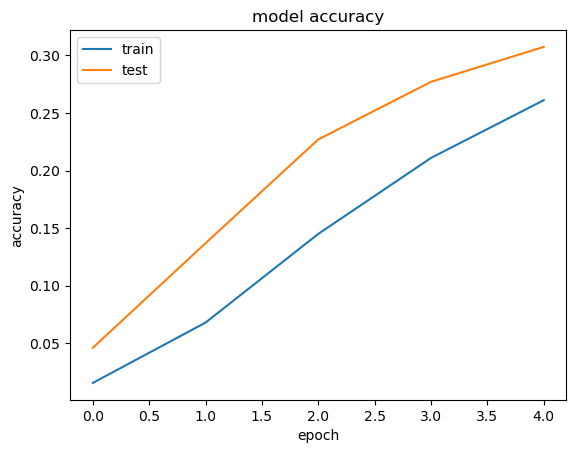

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

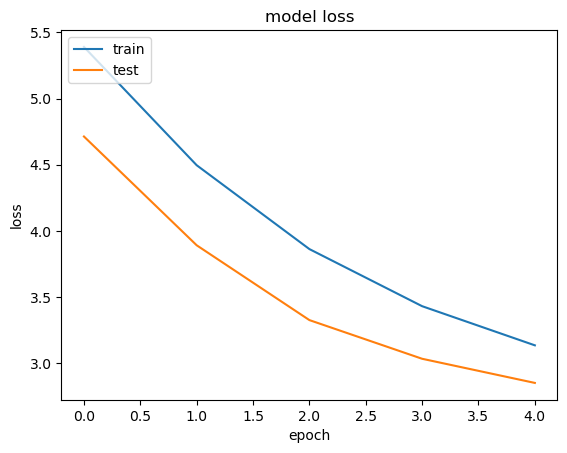

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Inference Model

In [11]:
class FeatureGenTF(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        

    def call(self, x):  
        if drop_z: 
            x = x[:, : , :-1]

        x = tf.gather(x, point_landmarks, axis=1)
                
        not_nan_frames = tf.where(tf.logical_not(tf.reduce_all(tf.reduce_any(tf.math.is_nan(x[:, 40:, :]), axis = 2), axis=1)))[0]
        
        x = tf.gather(x, not_nan_frames, axis=0) #I think axis 0 is still the frame numbas
                
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        
        x = tf.image.resize_with_pad(x, max_length, len(point_landmarks))  
                
        x = tf.reshape(x, (max_length, len(point_landmarks)*len(data_columns)))
        
        x = tf.expand_dims(x,0) # THIS IS SAYING BATCH SIZE ONE TO MODEL YEAAAA
        
        return x
    
preprocessing = FeatureGenTF()

In [12]:
def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs") 
    x = preprocessing(inputs)
    x = model(x)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return inference_model

inference_model = get_inference_model(model)
inference_model.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 543, 3)]          0         
                                                                 
 feature_gen_tf (FeatureGenT  (1, 60, 164)             0         
 F)                                                              
                                                                 
 sequential (Sequential)     (None, 250)               1702650   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| masking (Masking)         (None, 60, 164)           0         |
|                                                               |
| dense (Dense)             (None, 60, 160)           26400     |
|                                                               |
| dropout (Dropout)         (None, 60, 160)           0         |
|                                                            

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()

model_path = "model.tflite"

with open(model_path, 'wb') as f:
    f.write(tflite_model)

!zip submission.zip $model_path

  adding: model.tflite (deflated 7%)


# Testing inference model

In [14]:
!pip install tflite_runtime
import tflite_runtime.interpreter as tflite

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

if local_inference_test: 
    #TODO Find out what signs the model is bad at inferring
    interpreter = tflite.Interpreter(model_path)
    found_signatures = list(interpreter.get_signature_list().keys())
    prediction_fn = interpreter.get_signature_runner("serving_default")
    p2s_map = {v: k for k, v in index_map.items()}
    decoder = lambda x: p2s_map.get(x)
    score = 0 
    for i in tqdm(range(int(len(train)/10))): 
        frames = load_relevant_data_subset(os.path.join(BASE_TRAIN_PATH, train.iloc[i].path))
        output = prediction_fn(inputs=frames)
        sign = np.argmax(output["outputs"])
        if decoder(train.iloc[i].label) == decoder(sign): 
            score += 1 
    print(score/int(len(train)/10))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.1 MB/s eta 0:00:00
